# Credit Risk
# Bachelor Thesis - Bocconi University 

## Credit risk modelling: an empirical analysis on Probability of Default (PD) estimation 
solution provided by: **Daniel Travaglia**

## Draft of the outline of the notebook

0. Introduction: frame the problem
1. Prerequisites: set up the environment
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning for modelling (missing values) 
5. Machine Learning Pipelines:
    - Model (1): Logistic Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model 
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model
6. Get the best model (metric comparison)
7. Evaluate the system on the test set and plot the results
8. Conclusions
9. (Bonus) Further improvements

## TODO

2) [TODO -> Today] Explanatory analysis + Give appropriate introduction and description

3) [TODO -> Today/Tomorrow] Calibration of default probability: since we do not have time-series data, we could actually calibrate default probabilities per-group: group by ratings and then by whether the client defaulted or not. At this point, estimate the probability of defaulting (modelling using a Bernoulli RV then) by calculating the proportion of defaulted clients out of the total clients for that specific rating 

4) [TODO -> Tomorrow] -> Provide a high-level overview of the credit risk world, with a particular attention in being able to introduce the topic in an understandable manner!

5) [TODO -> Today] -> injecting interest rates (missings) based on the information provided by ratings (random sampling between min-max of int. rates for a specific ranking) -> replacing missing values

# (0) Introduction: frame the problem

[TODO]: Provide a high-level description of what is credit risk modelling, what characterize it and how this activity is usually done in financial istitutions. Particular attention on PD, EAD and LGD.

# (1) Set up the environment

In this section the core libraries that will be used throughout the entire notebook are loaded. 
* NumPy and Pandas provide the fundamental tools to handle datasets and arrays.
* Skikit-learn provides amazing tools that simplify quite significantly the modelling part.
* Last but not least, matplotlib and seaborn are amazing libraries that enables to create effective visualizations to explore the data even further.

### (0.1) Retrieving libraries

In [2]:
# Data manipulation ML libraries
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.stats import norm

# Ignore irrelevant warnings to make the code nicer!
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# database libraries
import pyodbc                       

# graphic settings
# Make things work smoother for plots
%matplotlib inline
# Se the backend of plotting to matplotlib
pd.options.plotting.backend = 'matplotlib'
# Change the style of seaborn graphs
cmap = "Blues_r"
sns.set(
    style="white", 
    palette=cmap, 
    color_codes=True, 
    font_scale=1.1
)

### (0.1) Loading data settings

In [3]:
## CSV
# Counterparty data path
cp_path = "data\counterparty.csv"
# Counterparty loans data path
loans_path = "data\counterparty_loans.csv"

In [4]:
## SQL Server

# # Defining connection string
# driver = "{SQL Server}"
# server = "DESKTOP-KI4LIGE" # retrieve this in SQL by typing @@SERVERNAME
# database = "Thesis"
# connection = "yes"
# conn_string = f"Driver={driver};Server={server};Database={database};Trusted_Connection={connection}"

# # Defining connection string
# conn = pyodbc.connect(conn_string)

# # Defining query to extract data from tables
# sql_cp_query = """
#     SELECT * 
#     FROM dbo.Counterparty
# """
# sql_cp_loans_query = """
#     SELECT *
#     FROM dbo.Counterparty_loan
# """

In [5]:
# MongoDB

# (2) Retrieve and describe the dataset

Goal of this section is to provide information on the structure of the dataset used for the analysis. To begin with, a high-level description of the two tables will be given. Later in the analysis, we will take a closer look at the data and conduct a sanity check to see whether the data is consistent and in line with expectations.

## (2.1) Loading the datasets

The data is spread across 2 different tables:

* **Counterparty**: dataset that contains some general characteristics and information regarding the counterparties 
* **Loans**: dataset that provides relevant information on the loans issed by financial istitutions.

Before proceeding, it is important to clarify that each counterparty from the "counterparty" table is associated with one (and only one) loan from the "loans" table. This means that there is a one-to-one mapping between counterparties and loans, which is not usually corresponding to a classic scenario within a financial or any other credit lending istitution that wish to model for some credit risk metrics. Indeed, the latters usually make use of time-series data, which often provide a credit history of all the accounts (i.e. each financial instruments that the financial istitution can provide to the client) for multiple periods. In this context, the scenario is completely different: we are dealing with a panel data. In particular, each observation represents a snapshot of the credit availability associated with a counterparty at a certain point in time, a characteristic that is shared among all the observations. In other words, we get rid of the time dimension. Clearly, this translates into two different approaches to estimate probability of default. A financial istitution might want to model the PD ("probability of default") taking into account time-dependent factors (e.g. market risk factor, macroeconomic scenarios and so om). However, the nature and the structure of the data force us in keeping things simple with a much less ambitious objective: we would like to estimate the proability that a counteparty default on its obligations by only taking into consideration its characteristics and that of the financial obligation, namely disregarding everything (e.g. market risk, FX risk, economic condition, etc..) besides credit risk related factors.

### (2.1.1) Retrieving data from CSV

In [6]:
# Retrieving counterparty data
df_cp = pd.read_csv(cp_path)
# Retrieving counterparty loans data
df_loans = pd.read_csv(loans_path)

# make sure the file is loaded
assert not (df_cp.empty and df_loans.empty)

### (2.1.2) Retrieving data from SQL server

In [7]:
# # Injecting data into pandas DateFrame
# df_cp = pd.read_sql(sql_cp_query,conn)
# df_loans = pd.read_sql(sql_cp_loans_query,conn)

# # Inspecting whether we have indeed extract something out of the SQL server
# assert not (df_cp.empty or df_loans.empty)

### (2.1.3) Retrieving data from MongoDB server

In [8]:
# MongoDB

## (2.2) A first glence at the data

In this section we will explore the counterparty table, its shape and a brief analysis on the observations to verify consistency in the data. We will then proceed with the same type of analysis on the loan table and, eventually, we will merge the two dataset to retrieve additional insights with a combined explanatory analysis.

### (2.2.1) Counterparties dataset

In [9]:
df_cp.shape

(32581, 7)

The counterparty dataset contains 32581 observations, each of which represents a specific counterparty. The latters are described is then described by 7 different features. Let's now dig a little bit more to discover what type of information we have on the counterparties

In [10]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cp                       32581 non-null  int64  
 1   cp_age                      32581 non-null  int64  
 2   cp_income                   32581 non-null  int64  
 3   cp_home_ownership           32581 non-null  object 
 4   cp_emp_length               31686 non-null  float64
 5   cp_person_default_on_file   32581 non-null  object 
 6   cp_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.7+ MB


The dataset provides the following information regarding the counterparties: 
* Age: age of the person 
* Income: personal income in $ (dollars)
* Home ownership: whether the person owns a house or it is supplied with in any other ways (RENT, MORTGAGE, ... or other financial instruments)
* Employment length: how long (in years) the person has been employed
* Person default on file: whether in the past the person has already defaulted or not on an obligation
* Credit history length: length of the credit grant in years up until now

Let's clarify some points that emerge from this simple table

1. It can be easily noticed that some observations for "employment length" variable are missing. This is a situation that must be handled somehow before proceeding into the modelling section.

2. We want to turn some variables (e.g. home ownership and person default on file) into categorical features. Such procedure will simplify our analysis quite significantly and it will be specially relevant for the modelling part.

At this point you might wonder: how's the data looks like?

In [11]:
df_cp.head()

id_cp  cp_age  cp_income cp_home_ownership  cp_emp_length  \
0      1      22      59000              RENT          123.0   
1      2      21       9600               OWN            5.0   
2      3      25       9600          MORTGAGE            1.0   
3      4      23      65500              RENT            4.0   
4      5      24      54400              RENT            8.0   

  cp_person_default_on_file  cp_person_cred_hist_length  
0                         Y                           3  
1                         N                           2  
2                         N                           3  
3                         N                           2  
4                         Y                           4

It seems that we have relevant information regarding the counterparties. It is worth discussing on the following point before proceeding: 

* Presence of (invalid) outliers: the first observation is characterized by a value for "employment length" that is clearly out of range: how could a person be employed for 123 years? And how would it be possible for a 22 years old person in the first place?

* The issue highlighted above might have further implications which are probably worth discussing before proceeding: we already hightlighted how it is important in a analytical project to have a rough idea of the context and to know what each variable represents. If combined with a proper explanatory analysis, it is possible to spot most of the inconsistencies in the data (i.e. bad/invalid outliers). However, this might not be enough: the counterparty could provide false information with the aim of increasing the likelihood to obtain the credit. Such setting is usually worst in presence of asymmetric information: the fact that one party is more informed that the other party might generate some inefficencies in the lending market. This topic will be subject of discussion for the last chapter of this paper.

Let's retrieve some statistics to see whether there is presence of other inconsistencies within the data.

In [12]:
df_cp.describe()

id_cp        cp_age     cp_income  cp_emp_length  \
count  32581.000000  32581.000000  3.258100e+04   31686.000000   
mean   16291.000000     27.734600  6.607485e+04       4.789686   
std     9405.468897      6.348078  6.198312e+04       4.142630   
min        1.000000     20.000000  4.000000e+03       0.000000   
25%     8146.000000     23.000000  3.850000e+04       2.000000   
50%    16291.000000     26.000000  5.500000e+04       4.000000   
75%    24436.000000     30.000000  7.920000e+04       7.000000   
max    32581.000000    144.000000  6.000000e+06     123.000000   

       cp_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

This table allows us to easily identify the incosistencies mentioned above: the maximum employment length among all observations is 123 years. In addition, the maximum registred age for a counterparty is 144 years. Such values will definetely require further investigation and manipulation to obtain a dataset on top of which we can work on. There seems to be also unemployed counterparties who took up a loan which might require further analysis. All the other numbers seem to be reasonably acceptable.

Removing inconsistencies from the counterparty table: people aged above 100 along with those that have more than 50 years of employment

In [13]:
# Retrieve the number of values which are not reasonable
df_invalid = df_cp[(df_cp.cp_age > 100) | (df_cp.cp_emp_length > 50)]
# Dropping absurd values from the dataset
df_cp.drop(index=df_invalid.index,inplace=True)

### (2.2.1.1) Univariate analysis on counterparty's data

This section aims at exploring the counterparties' features even further through some visualization tools. Particular attention will be given to the distribution of the data and whether it is possible to discover something more

In [14]:
# Create a copy for analysis purposes
df_cp_analysis = df_cp.copy().drop(columns=["id_cp"]).dropna()

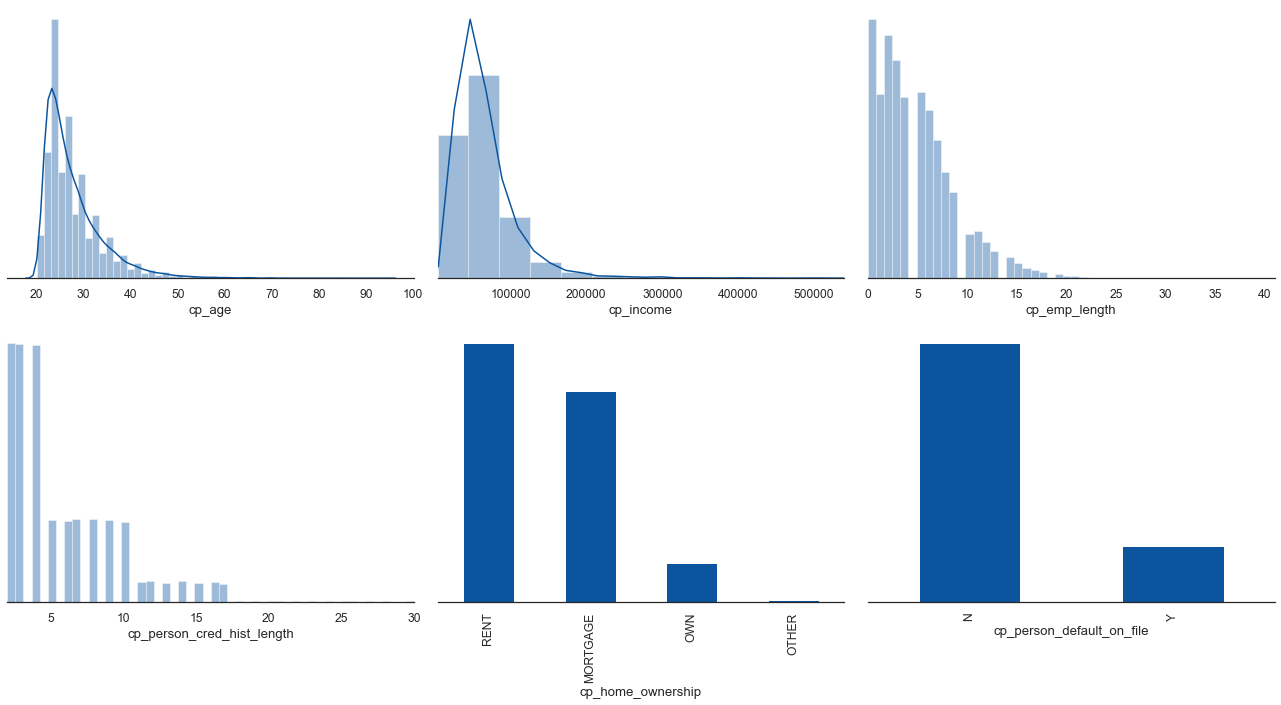

In [15]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Age distribution (with no density estimation)
fig_age = sns.distplot(df_cp_analysis.cp_age,kde=True,ax=axes[0,0])
# fig_age.axis(xmin=df_cp_analysis.cp_age.min() - 10, xmax=df_cp_analysis.cp_age.max() + 10)

# (2) Income distribution (with density estimation)
fig_income = sns.distplot(df_cp_analysis.cp_income,kde=True,ax=axes[0,1])
fig_income.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max() - 1.5e6)

# (3) Employment length distribution (with density estimation)
fig_emp_leng = sns.distplot(df_cp_analysis.cp_emp_length,kde=False,ax=axes[0,2])
fig_emp_leng.axis(xmin=df_cp_analysis.cp_emp_length.min(), xmax=df_cp_analysis.cp_emp_length.max())

# (4) Credit history length distribution (with no density estimation)
fig_cr_hist = sns.distplot(df_cp_analysis.cp_person_cred_hist_length,kde=False,ax=axes[1,0])
fig_cr_hist.axis(xmin=df_cp_analysis.cp_person_cred_hist_length.min(), xmax=df_cp_analysis.cp_person_cred_hist_length.max())

# (5) Home ownership data 
fig_home = df_cp_analysis.groupby(["cp_home_ownership"])["cp_home_ownership"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not in the past 
fig_def = df_cp_analysis.groupby(["cp_person_default_on_file"])["cp_person_default_on_file"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,2])

plt.setp(axes, yticks=[])
plt.tight_layout()

The image above includes the univariate distribution of all the numerical features of the counterparty dataset as well as some representation for all the categorical features. Few things stand out here:

* As we have already noticed, almost the entire set of counterparties is represented by people between their 20s and their 40s. As expected, the age distribution has an impact also on all the other variables that will be described in the next points. 

* Lower age translates into shorter employment periods and credit history length. In particular, there seems to be a great portion of unemployed people as well as a very large amount of counterparties with little-to-none credit history. Intuitevely, unemployment should have high impact on the assessment of PD of a counterparty. 

* A very small number of counterparties owns a house, while the majority is either renting or on a mortgage. The latter would proably need further analysis, as these people already took upon themselves other debt to be repaid at a certain poin in time. Hence, the question becomes whether these individuals have enough income to sustain another obligation for an extended period of time.

* The most representative class of counterparties have not defaulted in the past on an obligation. This information should turn out to be of massive importance when factored in the PD model.

* Lastly, the income distribution is skewed to the left and the plot against a gaussian density seems to confirm this hypothesis. Why is this important? Well, the relevance of having normally distributed features is due to the fact that several statistical tests (e.g. t-statistic) take by assumption normally distributed data. However, as we will see later, since we will have to model a binary dependent variable (i.e. can take either value 0 or 1), the models that will be used do not have any assumptions about normally distributed explanatory variables.

Before proceeding with the dataframe that describe the loans, let's have a look at some of the points mentioned above individually.

#### (1) % of unemployed?

In [16]:
# Retrieve unemployement rate
df_cp_perc_unemp = df_cp_analysis[df_cp_analysis.cp_emp_length == df_cp_analysis.cp_emp_length.min()]["cp_emp_length"].count() / df_cp_analysis.shape[0]
# Print out the number
print(f"{df_cp_perc_unemp * 100:.2f}% of counterparties is unemployed")

12.96% of counterparties is unemployed


This is a relatively high number of unemployed counterparties. This set of people might need, along with the information on the obligation they have, an independent analysis to see how they influence the likelihood of defaulting on such loan

#### (2) % of counterparties with mortgages?

In [17]:
# Retrieve unemployement rate
df_cp_perc_mort = df_cp_analysis[df_cp_analysis.cp_home_ownership == "MORTGAGE"]["cp_home_ownership"].count() / df_cp_analysis.shape[0]
# Print out the number
print(f"{df_cp_perc_mort * 100:.2f}% of counterparties have a mortgage")

41.32% of counterparties have a mortgage


More than one-third of the observations declared that they are already sustaining some kind of debt, but there could be more. In any case, as for unemployed people, such pool might need a further analysis to see how this information impact our dependent variable

#### (3) Normality of counterparties income -> TO BE DELETED: NOT REQUIRED!

((array([-4.08667367, -3.87592463, -3.76082609, ...,  3.76082609,
          3.87592463,  4.08667367]),
  array([   4000,    4080,    4200, ..., 1782000, 1900000, 2039784],
        dtype=int64)),
 (40032.94348825559, 66490.0991824237, 0.7585647032775285))

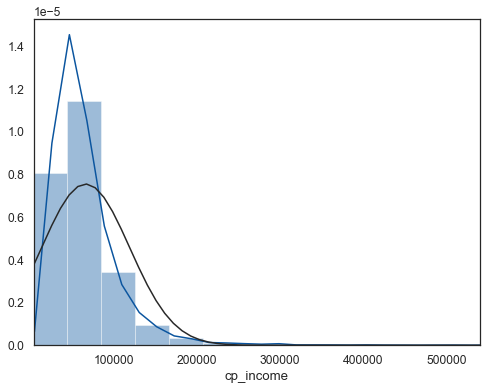

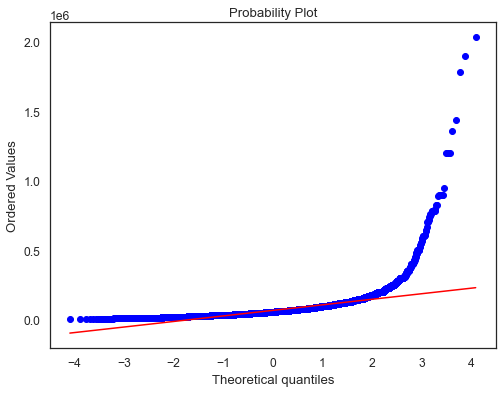

In [18]:
# Normality of counterparty income
fig_age = plt.figure(figsize=(8,6))
fig_age = sns.distplot(df_cp_analysis.cp_income,kde=True,fit=norm)
fig_age.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max() - 1.5e6)

# QQ Plot
fig = plt.figure(figsize=(8,6))
stats.probplot(df_cp_analysis.cp_income,plot=plt)

As we have already highlighted above, the income feature is not normally distributed. This can be simply achieve through a monotonic transformation, such as the logarithmic transformation. 

[TODO] ? Such transformation will just affect the underlying distribution of the feature, but will not have any affect on all the other characteristics of the data (e.g. min and max) 

((array([-4.08667367, -3.87592463, -3.76082609, ...,  3.76082609,
          3.87592463,  4.08667367]),
  array([ 8.29404964,  8.31385227,  8.3428398 , ..., 14.39324689,
         14.45736444, 14.52835448])),
 (0.5565052788922281, 10.937224844914642, 0.996163583885624))

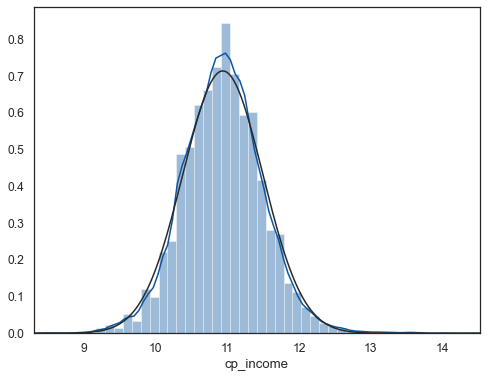

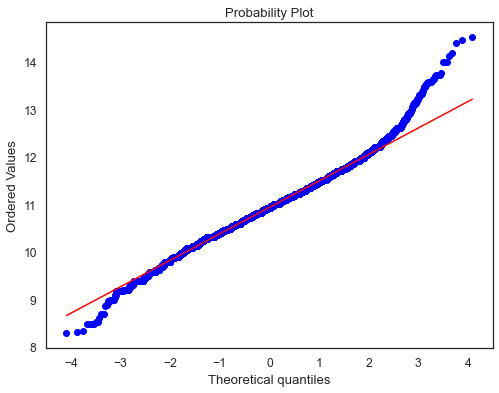

In [19]:
# Apply log transformation
df_cp_analysis.cp_income = np.log(df_cp_analysis.cp_income)

# Reproduce plot
fig_age = plt.figure(figsize=(8,6))
fig_age = sns.distplot(df_cp_analysis.cp_income,kde=True,fit=norm)
fig_age.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max())

# QQ Plot
fig = plt.figure(figsize=(8,6))
stats.probplot(df_cp_analysis.cp_income,plot=plt)

Mission accomplished: although there is still presence of skewedeness, the distribution is really close to a gaussian one. 

## (2.2.2) Loans dataset

Let's now switch to the loans dataset. This table provides information regarding single loans that were given to counterparties by means of a financial istitution

In [20]:
# Dropping useless features for analysis and NAN values
df_loans_analysis = df_loans.drop(columns=["id_loan","fk_cp"]).dropna()
df_loans_analysis.shape

(29465, 6)

The dataset on loans has less observations than the dataframe on counterparties due to the presence of null values that were discarded for analysis purposes. Nevertheless, the dataframes match in a one-to-one relationship between counterparties and loans (i.e. 1 counterparty = 1 loan). Moreover, each loan is described by 6 different features.

In [21]:
df_loans_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29465 entries, 0 to 32580
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_intent          29465 non-null  object 
 1   loan_grade           29465 non-null  object 
 2   loan_amount          29465 non-null  int64  
 3   loan_int_rate        29465 non-null  float64
 4   loan_status          29465 non-null  int64  
 5   loan_percent_income  29465 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.6+ MB


The following information on loans are provided:

* Loan intent: reason provided to get the loan

* Loan grade: the rating associated with the loan and the relative counterparty. This gives us insights on the risk associated with this loan, and it is usually driven by the loan characteristics, as well as counterparties characteristics

* Loan amount: the amount of the loan

* Loan interest rate: the interest rate associated with the loan.

* Loan status: whether the counterparty has defaulted or not on such loan (1 is defaulted, 0 is not). This is going to be our dependent variable: we want to estimate the probability that a customer is going to default given certain characteristics on the loans (loans dataset) along with characteristics on the counterparty itself (counterparty dataset)

* Loan percent income: the proportion of the loan amount with respect to the income of the relative counterparty 

It seems that a huge amount of observations do not have information on the interest rate applied to the loan. Being an indicator of how risky the investment is, one possibility to get rid of these missing values could be represented by applying a map between ratings and interest rates and replace them based on a random sampling within the range of the interest rate for a specific category (i.e. loan_intent) and for the rating characterizing such loan (i.e. loan_grade). Through such procedure however, there is the risk of injecting biased information in the data that might lead eventually to have a model with bad predictiory power.

In [22]:
df_loans_analysis.head()

loan_intent loan_grade  loan_amount  loan_int_rate  loan_status  \
0    PERSONAL          D        35000          16.02            1   
1   EDUCATION          B         1000          11.14            0   
2     MEDICAL          C         5500          12.87            1   
3     MEDICAL          C        35000          15.23            1   
4     MEDICAL          C        35000          14.27            1   

   loan_percent_income  
0                 0.59  
1                 0.10  
2                 0.57  
3                 0.53  
4                 0.55

The first observations do not signal any particular concern on the data. Let's see whether this is also confirmed by the statistics.

In [23]:
df_loans_analysis.describe()

loan_amount  loan_int_rate   loan_status  loan_percent_income
count  29465.000000   29465.000000  29465.000000         29465.000000
mean    9584.744612      11.011695      0.219379             0.170110
std     6316.272282       3.240459      0.413833             0.106879
min      500.000000       5.420000      0.000000             0.000000
25%     5000.000000       7.900000      0.000000             0.090000
50%     8000.000000      10.990000      0.000000             0.150000
75%    12250.000000      13.470000      0.000000             0.230000
max    35000.000000      23.220000      1.000000             0.830000

All the numerical features seem reasonably within the expected range. Apparently, there are some observations that present a loan amount w.r.t. the income of the counterparty equal to 0, despite the minumum loan amount being equal to 500. This signal presence of inconsistencies that should be carefully analyzed and handled as soon as we have a comprehensive view of each loan with its respective counterparty. Moreover, few things can already be highlighted here before proceeding with the analysis:

1) As we have seen before, "loan status" is a binary feature: it only takes values 1 or 0 depending on whether the counterparty already defaulted or not on the loan respectively. The average value of the distribution of this feature is skewed towards 0, which suggests that we are provided with an unbalanced set. In other words, there is presence of more non-defaulting loans than the defaulted ones. Nevertheless, as we will see later in this analysis, such finding will not have any impact on the model.

2) Suspicious numbers in the "loan over income" feature will be subject of later analysis. However, the mean and the standard deviation of the distribution of this feature suggest that the amount of the loans is just a small percentage of the overall counterparty's income. This might be a good reason for which we have many more non-defaulting loans in the dataset, but such assumption would definetely require a much closer look at the data.

3) The average interest rate on loans is pretty high (even respect to the distribution of the loan amounts), but given the figure highlighted above for "loan_percent_income", these numbers should be sustainable in the long-term by counterparties 

This analysis should be further supported with some visualizations and statistics to provide richer insights in an attempt to discover hidden patterns. This will be the subject of the next chapter.

#### Deal with data inconsistencies - "loan_percent_income"

In [24]:
# (1) Retrieve inconsistencies
df_loans_invalid = df_loans_analysis[df_loans_analysis.loan_percent_income == 0]

# (2) Merge with counterparty dataframe
df_loans_invalid_merged = pd.merge(df_loans_invalid,df_cp,how="inner",left_index=True,right_index=True)

# (3) Display data
df_loans_invalid_merged

loan_intent loan_grade  loan_amount  loan_int_rate  loan_status  \
17834           PERSONAL          B         2000           9.99            0   
18917           PERSONAL          C         1800          13.48            0   
27877    HOMEIMPROVEMENT          A         2500           7.43            0   
30049            VENTURE          C         8450          12.29            0   
31916    HOMEIMPROVEMENT          A         1000           8.94            0   
31922            VENTURE          A         6600           7.74            0   
31924  DEBTCONSOLIDATION          A         6400           7.40            0   

       loan_percent_income  id_cp  cp_age  cp_income cp_home_ownership  \
17834                  0.0  17835      34     948000          MORTGAGE   
18917                  0.0  18918      35     510000              RENT   
27877                  0.0  27878      30     522000          MORTGAGE   
30049                  0.0  30050      42    2039784              RENT   
31916                  0.0  31917      43     780000          MORTGAGE   
31922                  0.0  31923      47    1362000          MORTGAGE   
31924                  0.0  31925      44    1440000          MORTGAGE   

       cp_emp_length cp_person_default_on_file  cp_person_cred_hist_length  
17834           18.0                         N                           7  
18917            1.0                         N                           6  
27877           11.0                         N                           9  
30049            0.0                         Y                          15  
31916            2.0                         N                          11  
31922            9.0                         N                          17  
31924            7.0                         N                          15

The feature "loan_prcent_income" can be computed by dividing the loan amount with the income of the respective counterparty. Such methodology stress another point: do we really need "loan_amount" and "cp_income" as explanatory variable for our model when the same information is captured by loan_percent_income variable? This question will be subject of further analysis in context of "correlation coefficients analysis"

In [25]:
# (4) Calculate the variable
df_loans_invalid_merged.loan_percent_income = df_loans_invalid_merged.loan_amount / df_loans_invalid_merged.cp_income

# (5) Store results in the original dataset (access by index and col)
df_loans_analysis.loc[df_loans_invalid_merged.index,["loan_percent_income"]] = df_loans_invalid_merged.loan_percent_income

# (6) Drop those observations that still has 0 as loan_percent_income due to asymmetry of dataframes
df_loans_analysis.drop(index=df_loans_analysis[df_loans_analysis["loan_percent_income"] == 0].index,inplace=True)

### (2.2.2.1) Univariate analysis on loans 

In [26]:
# Columns to be explored
df_loans_analysis.columns

Index(['loan_intent', 'loan_grade', 'loan_amount', 'loan_int_rate',
       'loan_status', 'loan_percent_income'],
      dtype='object')

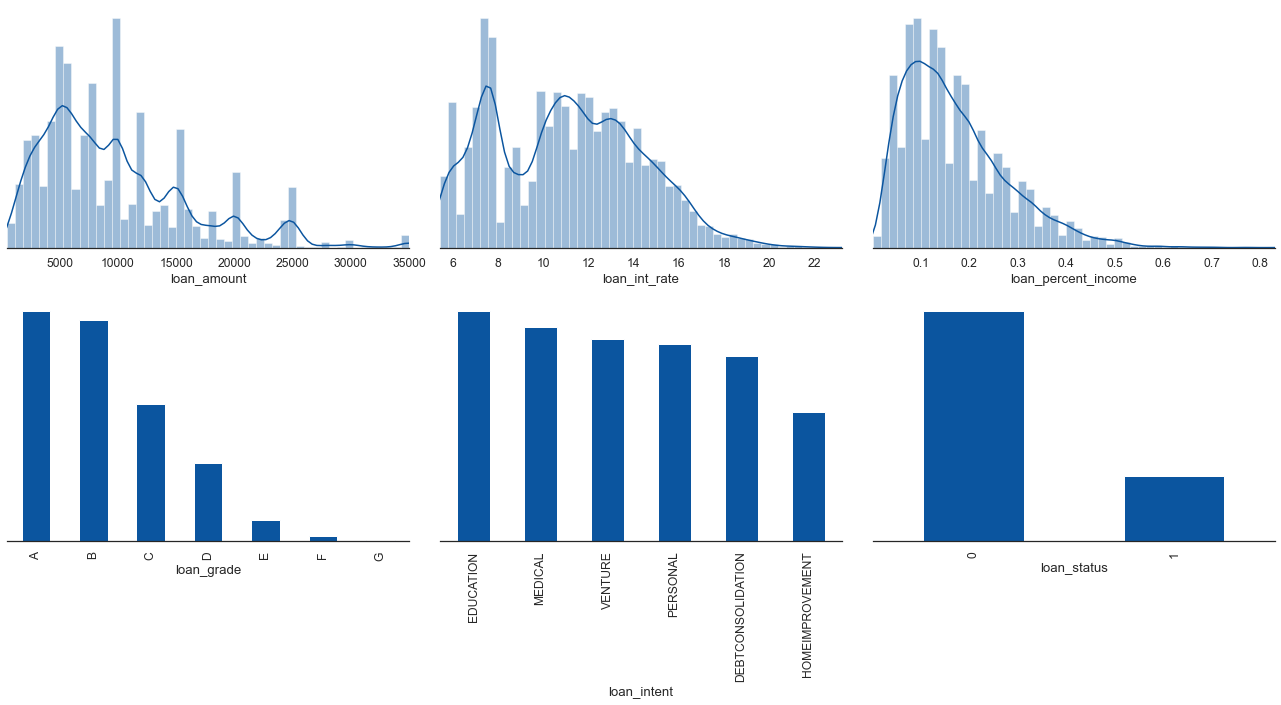

In [27]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Amount of the loan
fig_amount = sns.distplot(df_loans_analysis.loan_amount,kde=True,ax=axes[0,0])
fig_amount.axis(xmin=df_loans_analysis.loan_amount.min(), xmax=df_loans_analysis.loan_amount.max())

# (2) Interest rate attached to the loan
fig_int_rate = sns.distplot(df_loans_analysis.loan_int_rate,kde=True,ax=axes[0,1])
fig_int_rate.axis(xmin=df_loans_analysis.loan_int_rate.min(), xmax=df_loans_analysis.loan_int_rate.max())

# (3) Loan amount over income of the counterparty
fig_lpi = sns.distplot(df_loans_analysis.loan_percent_income,kde=True,ax=axes[0,2])
fig_lpi.axis(xmin=df_loans_analysis.loan_percent_income.min(), xmax=df_loans_analysis.loan_percent_income.max())

# (4) Rating attached to the loan 
fig_grade = df_loans_analysis.groupby(["loan_grade"])["loan_grade"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,0])

# (5) Counterparty intent to go for a loan
fig_intent = df_loans_analysis.groupby(["loan_intent"])["loan_intent"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not on the loan 
fig_status = df_loans_analysis.groupby(["loan_status"])["loan_status"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,2])

plt.setp(axes, yticks=[])
plt.tight_layout()

The image above shows the univariate distributions of the features describing the loans. Although we have already introduced some of the key takeaways, there are some additional aspects that we might want to take into consideration before proceeding:

* The loan amount is mostly concentrated around 5-10K, which is a relatively low number with respect to the income of counterparties. This aspect is indeed captured by the distribution of the "loan_percent_income", which should intuitevely represent a key feature to model for PD.

* Most of the loans have been classified as relatively safe loans (i.e. loan_grade being either A,B,C) and given the non-defaulting amount, it might be the case that they have been graded correctly. However, further analysis would be require to provide evidence of this.

* "Education" is the most represented class among the intents expressed from counterparties to ask for the loan. In any case, there seems to be an overall balance of classes of intents in the dataset. One additional thing stands out: "debt consolidation" intent. Debt consolidation is a way to sort of re-negotiate your debt by taking up additional debt, but at a much lower interest rate. Clearly, these counterparties have been much more exposed to default than other counterparties in the dataset and therefore, there might be the need to conduct further analysis and see whether there are evidences of this fact. 

We can finally proceed exploring the combine dataset through multivariate analysis and see whether we can spot any relationship in the data

## (2.3) A combined analysis: multivariate

This section focuses on multivariate analysis with the objective of comparing multiple variables and see whether we can find any additional information or even hidden patterns in the data that might be useful for modelling purposes. Visualizations here will be a key tool for our purposes and for this reason, they will guide us along the way.

In [28]:
# Merge the two datasets
df_analysis = pd.merge(df_cp_analysis,df_loans_analysis,how="inner",left_index=True,right_index=True)
print("Datasets have been merged")

Datasets have been merged


In [29]:
# Get a few information on the new dataset
print(f"The dataset is characterized by {df_analysis.shape[0]} observations and {df_analysis.shape[1]} features")
df_analysis.head()

The dataset is characterized by 28632 observations and 12 features


cp_age  cp_income cp_home_ownership  cp_emp_length  \
1      21   9.169518               OWN            5.0   
2      25   9.169518          MORTGAGE            1.0   
3      23  11.089805              RENT            4.0   
4      24  10.904119              RENT            8.0   
5      21   9.200290               OWN            2.0   

  cp_person_default_on_file  cp_person_cred_hist_length loan_intent  \
1                         N                           2   EDUCATION   
2                         N                           3     MEDICAL   
3                         N                           2     MEDICAL   
4                         Y                           4     MEDICAL   
5                         N                           2     VENTURE   

  loan_grade  loan_amount  loan_int_rate  loan_status  loan_percent_income  
1          B         1000          11.14            0                 0.10  
2          C         5500          12.87            1                 0.57  
3          C        35000          15.23            1                 0.53  
4          C        35000          14.27            1                 0.55  
5          A         2500           7.14            1                 0.25

In [30]:
# Define function for plotting
def sns_multivariate(*plot_args):

    # Retrieve graph options
    plot_dict = plot_args[0]
    plot_options = plot_dict["plot_options"]

    # Settings
    plt.figure(figsize=(12,7))
    df_plot = plot_dict["df"]
    x = plot_dict["x"]
    y = plot_dict["y"]

    # Differentiate between graphs

    if plot_options["kind"] == "bar":
        g = sns.barplot(x=x, y=y, data=df_plot,palette=plot_options["palette"])
    elif plot_options["kind"] == "count":
        g = sns.countplot(x=x,hue=plot_options["hue"],palette=plot_options["palette"],order=plot_options["order"])
        g.legend(loc="upper left")
    elif plot_options["kind"] == "boxplot":
        g = sns.boxplot(data=df_plot,x=x,y=y)
    elif plot_options["kind"] == "violin":
        g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_options["hue"],inner="quart",split=True)
    elif plot_options["kind"] == "scatter":
        g = sns.scatterplot(x=x.x,y=y,data=df_plot,s=40,color="m")
    elif plot_options["kind"] == "pairplot":
        g = sns.pairplot(df_plot,kind="scatter")
    else:
        raise Exception("Not a valid graph option")

    # Options shared for each graph
    for p in g.patches:
        g.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0,10), textcoords = 'offset points')
    g.set_title(plot_options["title"],fontsize=20,fontweight="bold")
    g.set_xlabel(plot_options["x_label"],fontsize=16)
    g.set_ylabel(plot_options["y_label"],fontsize=16)

print("Multivariate plot function is ready to use")

Multivariate plot function is ready to use


### (2.3.1) Correlation Analysis

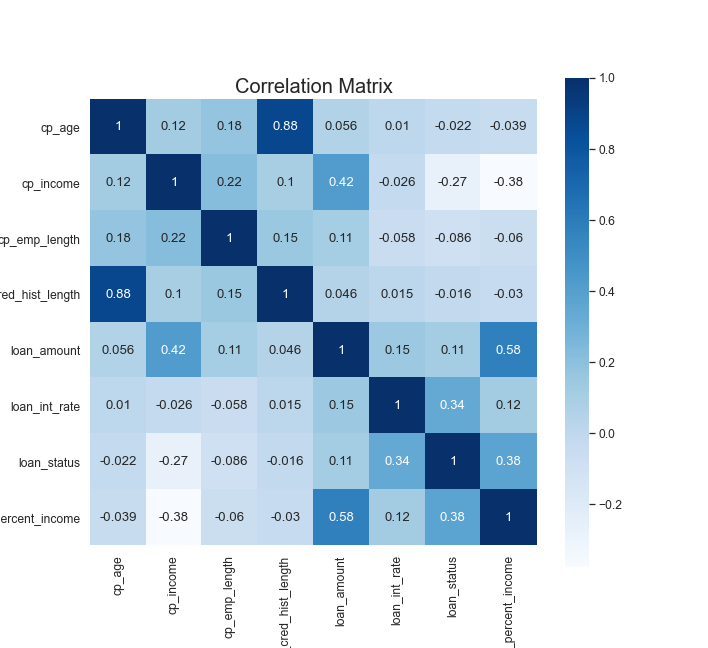

In [33]:
# General correlation matrix
corr_matr = df_analysis.corr()

# Plots
f,ax = plt.subplots(figsize=(10,9))
ax.set_title("Correlation Matrix",fontsize=20)

# Heatmap
sns.heatmap(corr_matr, square=True, cmap="Blues",annot=True);

# Comments
#   (1) Age - cred_hist_length -> high correlation: explain reason and see whether we can exclude one of the two later
#   (2) Loan_percent_income -> correlation with loan_amount, but not so high with income... which I would expect
#   (3) Loan status, although binary, shows correlation with loan_percent_income and interest rate applied. This makes sense as the higher the both, the higher the loan_status, for which 1 represents defaulted clients

The **correlation coefficient** gives insights on the **linear relationship** between two variables. This coefficient ranges between \[-1,1] based on the intensity of such relationship: if positive (i.e. between \(0,1]) then the two variables are said to be "positively correlated" or, in other words, when one variable increases the other follows and viceversa. If instead this coefficient is negative (i.e. between \[-1,0)), then we are in a situation of "inversely correlated" variables: the increment of one of the two variables causes the other to drop.

The correlation matrix allows to extend this analysis for each of the possible combinations of numerical features in our dataset. The figure above provides already some key insights that are summarized in the following points:

* The age of the counterparty drives the relative credit history length. This is quite intuitive, as you would expect that the older a persong gets, the more likely it is that this person has been in a credit contract for a longer period of time.

* The variable representing the metric "loan over income" is correlated with both loan amount and counterparty income. Despite the presence of correlation, this number is surprisingly not as high as expected. This might be driven by the presence of other type of relationships which cannot be captured by the correlation coefficient.

* The loan amount is indeed correlated with the income of the counterparty to which the loan has been given. The intuition behind might be that the higher the income, the more likely it is for this person to sustain even higher repayments in the future (i.e. the principal and the interest rates of the loan)

* Lastly, although it is not usually appropriate to include a binary variable in the correlation analysis as it might results from too simplistic conclusions, some surprising results pop up here: the loan status is positively correlated with both interest rate and loan over income. The reasoning behind might be the following: since loan status takes value 1 when the counterparty has defaulted on that loan, the higher the interest rate and the loan amount with respect to the counterparty's income, the more likely it gets that a counterparty default on this loan.

Linear relationships are a great starting point to explore relationships among variables. Proceeding, we might want to see whether there are also some other trends that we can capture using other visualization tools, such as **non-linear relationships**

In [ ]:
# CLOSER LOOK AT LOAN_STATUS AS CORRELATION MATRIX HERE?

### (2.3.2) Bivariate plots

In [74]:
# Retrieve counterparty data
cp_cols_num = ['cp_age','cp_income','cp_emp_length','cp_person_default_on_file','cp_person_cred_hist_length']
cp_cols_cat = ['cp_home_ownership','cp_person_default_on_file']

# Get the data
df_cp_num = df_analysis[cp_cols_num]
df_cp_cat = df_analysis[cp_cols_num]

In [80]:
# Counterparties attributes
plot_args = {
    "df": df_cp_num,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "pairplot",
        "title": "Distribution of counterparties attributes",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Plot
sns_multivariate(plot_args)

AttributeError: 'PairGrid' object has no attribute 'patches'

# (3) Data manipulation 

In [14]:
# mapping defaulted on file into 0-1 variables
mapping_defaulted = {
    "Y":1,
    "N":0
}
# modify the dataframe to respect this convention
df.loc[:,'cp_person_default_on_file'] = df.cp_person_default_on_file.map(mapping_defaulted)

# assert 
assert not np.any((df.cp_person_default_on_file == "N") & (df.cp_person_default_on_file == "Y"))

As a last step, let's turn the non-numeric variables into categorical.

In [15]:
# Get categorical variables
for col in ('cp_home_ownership','cp_person_default_on_file','loan_intent','loan_grade','loan_status'):
    df[col] = pd.Categorical(df[col])

# check 
df.dtypes

cp_age                           int64
cp_income                        int64
cp_home_ownership             category
cp_emp_length                  float64
cp_person_default_on_file     category
cp_person_cred_hist_length       int64
loan_intent                   category
loan_grade                    category
loan_amount                      int64
loan_int_rate                  float64
loan_status                   category
loan_percent_income            float64
dtype: object

### Let's have a closer look at the counterparties characteristics

In [66]:
# Retrieve counterparty data
cp_cols_num = ['cp_age','cp_income','cp_emp_length','cp_person_default_on_file','cp_person_cred_hist_length']
cp_cols_cat = ['cp_home_ownership','cp_person_default_on_file']

# Get the data
df_cp_num = df_analysis[cp_cols_num]
df_cp_cat = df_analysis[cp_cols_num]

Exception: Not a valid graph option

In [ ]:
# Counterparties attributes
plot_args = {
    "df": df_cp_num,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "pairplot",
        "title": "Distribution of counterparties attributes",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Plot
sns_plot(plot_args)

### (3.1) First things first: dig into the dependent variable 

In [56]:
# Retrieve the data
df_ls = df_analysis['loan_status'].value_counts().reset_index()

# Mapping to correct values
ls_dict = {
    0: 'Not defaulted (=0)',
    1: 'Defaulted (=1)'
}
df_ls['index'] = df_ls['index'].map(ls_dict)

# Retrieve loan status
df_ls

index  loan_status
0  Not defaulted (=0)        22430
1      Defaulted (=1)         6202

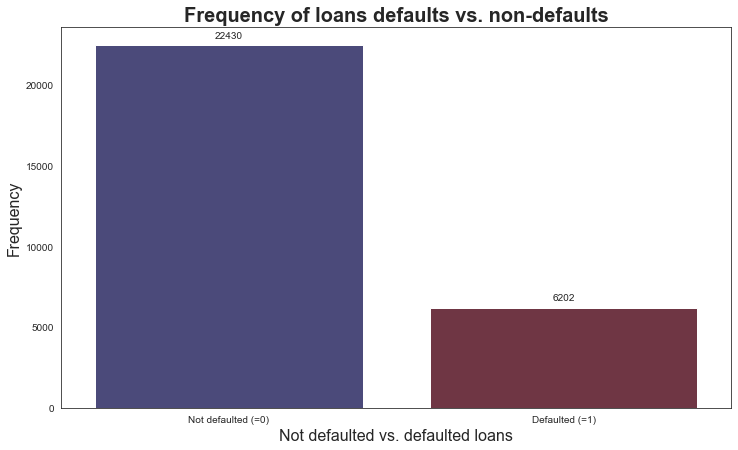

In [57]:
# Distribution of "loan_status" -> dependent variable
plot_args = {
    "df": df_ls,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "bar",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

Comment: unbalanced class of defaulted vs. non-defaulted counterparties in the dataset. However, this is not a classification, but a regression task. Hence, overbalancing (SMOTE) is not required in this situation, as it is normal to assume that the class of non-defaulted clients is the one that is represented the most in this context.

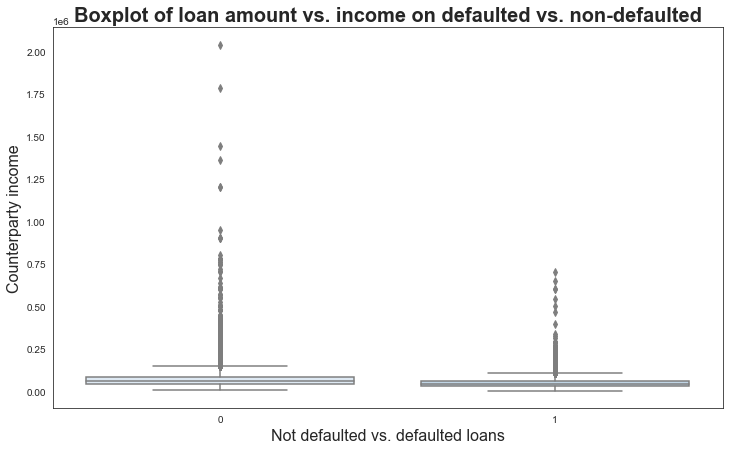

In [63]:
# How is the distribution of income across these categories of loans?
# Loan-status vs. cp_income
plot_args = {
    "df": df_analysis,
    "x": "loan_status",
    "y": "cp_income", 
    "plot_options": {
        "kind": "boxplot",
        "title": "Boxplot of loan amount vs. income on defaulted vs. non-defaulted",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Counterparty income",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

It can be noticed that most of the counterparties in both groups seem to have low income. This fact might be given by the strong presence of young people representing counterparties, who might have lower salaries/income with respect to older people, and thus more inclined to default on such loans. Let's have a closer look at this hypothesis

In [74]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_income",
    "y": "cp_age", 
    "plot_options": {
        "kind": "scatter",
        "title": "",
        "x_label": "",
        "y_label": "",
        "palette": "",
        "type": "mult"
    }
}

# Get the distribution
sns_plot(plot_args)

AttributeError: 'str' object has no attribute 'x'

In [ ]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "violin",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)